## Hyperplane folding.

The following code runs the algorithm from the paper:
*Hyperplane folding - a way to increase the margin in Support Vector Machines
*Lars Lundberg, Håkan Lennerstad, Eva Garcia-Martin, Niklas Lavesson and Veselka Boeva

It does the following:
1. Apply SVM in a dataset
2. Select the primary support vector
3. Divide the points into two, ones to the left of the support vector (forming an orthogonal line with the hyperplane) and the other ones to the right of the support vector
4. Apply two SVM on each new set of points
5. Rotate one side an angle a. 
6. The margin has thus increased from the initial one. 

In [109]:
"""
Simulation functions
"""

def generate_point(center, radius):
    #Generate a random vector on the unit circle (length 1)
    ang = uniform(0, 2*pi)
    v = np.array([cos(ang), sin(ang)])
 
    # Generate a normally distributed length
    #(mean = 0, so the length can be negative)
    l = radius + 1
    while abs(l) > radius:
        l = normalvariate(0, radius)
    return center + l * v


def generate_points(centers, points_per_circle, radius):
    X = list()
    Y = list()
    count = 1
    
    for center in centers:
        for i in range(points_per_circle):
            X.append(generate_point(center, radius))
            if count%2:
                Y.append(0)
            else:
                Y.append(1)
        count += 1
        
    X=np.array(X)
    Y=np.array(Y)
    return (X,Y)

def get_margin(clf):
    w = clf.coef_[0]
    a = -w[0] / w[1]
    s_vectors = clf.support_vectors_
    intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
    intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
    margin = (abs(intrc_up - intrc_down))/(math.sqrt(1+(a*a)))
    return margin

def plot_SVM(clf,x,y, should_plot):
    if should_plot: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(x[:,0].min(),x[:,0].max())
        intercept = -(clf.intercept_[0]) / w[1]
        s_vectors = clf.support_vectors_

        # Margin
        intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
        intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
        yy = a * xx + intercept
        yy_up = a * xx + intrc_up
        yy_down = a * xx + intrc_down

        pdf = PdfPages('SVM' + str(time.clock()) + '.pdf')
        fig=figure(figsize=(6,4))
        
        plt.plot(xx, yy, 'k-')
        plt.plot(xx, yy_down, 'k--')
        plt.plot(xx, yy_up, 'k--')

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],s=80, facecolors='none')
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
    
def get_support_vector(X, Y, supp):
    
    s=0
    supp_v=0
    for i in supp:
        s += Y[i]
    for n in supp:
        if Y[n] == 1 and s == 1:
            return X[n]
        if Y[n] == 0 and s== 2:
            return X[n]
        
def point_vs_othline(point, supp,  a ): 
    t= (point[0] - supp[0])/(-a)
    if point[1] <= supp[1] + t:
        return "higher/right"
    else:
        return "lower/left"
    
def split2 (X,Y, clf, prime_sv):
    r"""
    Splitting the points in X and Y, based on an orthogonal line to the hyperplane
    obtained by the classifier clf
    
    return: both sets of points
    """
    suppsum = 0
    set1x=list()
    set2x=list()
    set1y=list()
    set2y=list()
    
    for item in clf.n_support_:
        suppsum+=item
    if suppsum >= 3: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        i=0
        for item in X:
            if (item[0]==prime_sv[0]) and (item[1]==prime_sv[1]):
                set1x.append(item)
                set1y.append(Y[i])
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a ) == "higher/right":
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a) == "lower/left":
                set1x.append(item)
                set1y.append(Y[i])
            else:
                print "There is something wrong. Point is not either higher nor lower"
            i+=1
    return [set1x, set1y, set2x, set2y]


def folding_point(clf1, clf2):
    
    w1 = clf1.coef_[0]
    a1 = -w1[0] / w1[1]
    intercept1= -(clf1.intercept_[0]) / w1[1]
    
    w2 = clf2.coef_[0]
    a2 = -w2[0] / w2[1]
    intercept2= -(clf2.intercept_[0]) / w2[1]
    
    xf = (intercept2-intercept1)/(a1-a2)
    yf = xf*a1 + intercept1
    
    angle = np.arctan(a1) - np.arctan(a2)
    return [xf,yf] , angle
    
def remove_supp (sx, sy, supp):
    
    index=0
    while sx[index][0] != supp[0] and sx[index][1] != supp[1]:
        index+=1
    sx = np.delete(sx,index, 0)
    sy = np.delete(sy,index)
    
    return sx,sy
    
def points_rotated(X, f_point, angle):
    
    i=0
    XR = np.zeros(X.shape)
    # 1. 2. and 3.
    for item in X:
        XR[i][0] = item[0] - f_point[0] 
        XR[i][1] = item[1] - f_point[1]
        
        x_p = np.cos(angle)*XR[i][0] - np.sin(angle)*XR[i][1]
        y_p = np.sin(angle)*XR[i][0] + np.cos(angle)*XR[i][1]
        
        XR[i][0] = x_p + f_point[0]
        XR[i][1] = y_p + f_point[1]
        i+=1
    return XR

def get_clf():
    """
    Return the classifier, so that we can test different classifiers and not only one
    We don't need to change the instance everywhere, which outputs many errors due to the manual
    change that it requires. 

    """
     
#     C = 1000000000
    return svm.NuSVC(kernel='linear', nu=0.0000001) 

def rotation(x,y,clf, plot = False):
    """
    Gets the main support vector. 
    Divides the dataset into 2,based on the orthogonal line 
    to the plane and the main support vector. 
    Apply SVM on both sides, rotate the one with the greatest margin. 
    """
    prime_sv = get_support_vector(x,y, clf.support_ )
    set1x, set1y, set2x, set2y = split2 (x, y, clf, prime_sv)
    clf_s1 = get_clf()
    clf_s1.fit(set1x, set1y)
    margin1 = get_margin(clf_s1)
    
    clf_s2 = get_clf()
    clf_s2.fit(set2x, set2y)
    margin2 = get_margin(clf_s2)
    
    f_point, angle = folding_point(clf_s1, clf_s2)
    supp = get_support_vector(x,y, clf.support_ )
    
    if margin1 > margin2: 
        part_rotated = "left"
        set1x_nosupp, set1y_nosupp = remove_supp (np.array(set1x), set1y, supp)
        XR = points_rotated(set1x_nosupp, f_point, -angle)
        x_rotated = np.concatenate((XR, np.array(set2x))) 
        y_rotated = np.concatenate ((np.array(set1y_nosupp),np.array(set2y)))
    else:
        part_rotated = "right"
        set2x_nosupp, set2y_nosupp = remove_supp (np.array(set2x), set2y, supp)
        XR = points_rotated(set2x_nosupp, f_point, angle)
        x_rotated = np.concatenate((np.array(set1x), XR)) 
        y_rotated = np.concatenate ((np.array(set1y), np.array(set2y_nosupp)))
    
    if plot:
        print "\nSVM Set 1: LEFT"
        plot_SVM(np.array(set1x), set1y, clf_s1,plot)
        print "\nSVM Set 2: RIGHT"
        plot_SVM(np.array(set2x), set2y, clf_s2,plot)
        
    return angle, part_rotated, x_rotated, y_rotated, prime_sv, f_point

def plot_points(x,y, should_plot):
    if should_plot:
        pdf = PdfPages('points' + str(time.clock()) + '.pdf')
        
        fig=figure(figsize=(6,4))
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
        


In [105]:
def load_dataset(filename):
    dataset = pd.read_csv('../../datasets/'+filename)
    return dataset

In [106]:
def project_points(dataset):
    """
    Projecting the points from 3D to 2D, so that they are orthogonal to the Z axis.
    Håkan Lennerstad's formulas
    
    1. Apply SVM on dataset
    2. Get pair of support vectors
    3. Choose the pair with the minumum distance 
    """
    
    X = dataset.iloc[:,:3]
    Y = dataset['class']
#     clf = svm.NuSVC(kernel='linear', nu=0.0000001)
    clf = get_clf()
    clf.fit(X, Y)
    
    print "MARGIN: " , get_margin(clf), "\n"
        
    # Calculating distance
    d1 = abs(np.linalg.norm(clf.support_vectors_[0]-clf.support_vectors_[1])) 
    d2 = abs(np.linalg.norm(clf.support_vectors_[2]-clf.support_vectors_[3]) )

    v = clf.support_vectors_[0]
    u = clf.support_vectors_[1]
    
    if d1 > d2:
        v = clf.support_vectors_[2]
        u = clf.support_vectors_[3]

    w = v - u
    W = np.linalg.norm(w)
    W_12 = np.linalg.norm(w[:2])

    cosTheta = (w[2])/W
    sinTheta = W_12/W

    R = [[None for y in range(0,3)] for x in range (0,3)]
    R = [[ ((w[2]/W) + (w[1]**2 * (1-(w[2]/W))/W_12**2)) , -w[0]*w[1]*(1-(w[2]/W))/W_12**2, -w[0]/W],
         [-w[0]*w[1]/W**2 * ((1-(w[2]/W))/W_12**2), w[2]/W + ((1-(w[2]/W))/W_12**2), -w[1]/W], 
         [w[0]/W , w[1]/W, w[2]/W]]

    X_projected = np.dot(X,R)
    print "X initial points: \n\n" , X
    print "\nX Projected points: \n\n" , X_projected
    
    X_projected = X_projected[:,:2]
    print "\nX Projected points after removing Z : \n\n" , X_projected
       
    return X_projected

In [117]:
# Simulation: Training. 

def training(X_projected, Y, iterations):
    """
    Training SVM on dataset
    """
    # Dictionary that saves the information of every rotation
    rotation_info = dict()
    
    # Data
    angle, part_rotated, x_rotated, y_rotated, prime_sv, f_point = None, None, None, None, None, None
    should_plot = True

    d_x = X_projected
    d_y = Y

    for i in range(0,iterations+1): 
        clf = get_clf() 
        clf.fit(d_x, d_y)
        margin = get_margin(clf)
        
        if i==0:
            print "\nInitial SVM. No rotation yet. Margin: {:f}".format(margin)
        else:
            print "Rotation {:d} . Rotating the {:s}. Margin: {:f}".format(i,part_rotated, margin)

        plot_SVM(clf,d_x, d_y, should_plot)
        angle, part_rotated, x_rotated, y_rotated, prime_sv, f_point = rotation(d_x, d_y, clf)

        rotation_info[str(i)] = {'margin': margin, 'clf': clf, 'angle': angle, 
                           'part':part_rotated, 'x_rotated': x_rotated, 
                           'y_rotated': y_rotated, 'prime_support_vector': prime_sv,
                           'f_point': f_point}

        d_x = x_rotated
        d_y = y_rotated

    print "Training"

In [70]:
# Simulation: Testing

def testing(dataset):
    print "Testing: Not doing anything atm"

MARGIN:  40.260913756 

X initial points: 

    f1   f2   f3
0  100    0    0
1    0  100  100
2   10   10   10
3  110   10  110
4   10  110   10
5  100  100  100

X Projected points: 

[[  2.11324865e+01   7.88675135e+01  -5.77350269e+01]
 [  5.77376558e+01  -1.15462167e+02   1.77635684e-15]
 [  7.88701424e+00  -3.65946536e+00  -5.77350269e+00]
 [  8.67545277e+01   1.74730212e+01  -1.21243557e+02]
 [  7.88964315e+00  -6.13866055e+01   5.19615242e+01]
 [  7.88701424e+01  -3.65946536e+01  -5.77350269e+01]]

X Projected points after removing Z : 

[[  21.13248654   78.86751346]
 [  57.73765584 -115.46216709]
 [   7.88701424   -3.65946536]
 [  86.7545277    17.47302118]
 [   7.88964315  -61.38660553]
 [  78.87014238  -36.59465363]]

Initial SVM. No rotation yet. Margin: 38.976549


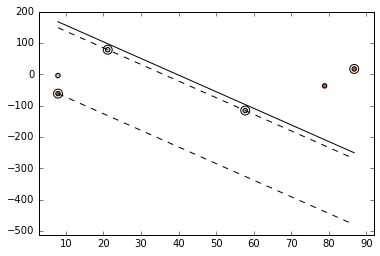

ValueError: The number of classes has to be greater than one; got 1

In [118]:
########################################
####             MAIN               ####
#### 30th June 2017                 ####
#### 3D case for hyperplane folding ####
#### 1. Projecting                  ####
#### 2. 2D case                     ####
########################################


# Import necessary packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math
import pandas as pd
from sklearn import datasets
from random import randint
from matplotlib.backends.backend_pdf import PdfPages
import time
from pylab import *

def main():
    iterations=2
    
    # Dataset
    dataset = load_dataset('toy_dataset.csv')
    Y = dataset['class']

    # Project the points
    X_projected = project_points(dataset)
   
    # Training 2D
    training(X_projected, Y, iterations)

    # Testing 2D
    testing(dataset)

    
if __name__ =='__main__':
    main()

In [104]:
""" 
Simulation. 
"""

def simulation(d0_x, d0_y, iterations, x_test, y_test, should_plot ):

    rotation_info = dict()
    clf.fit(d0_x, d0_y)
    margin = get_margin(clf)

    datasets['0'] = {'margin':margin , 'clf':clf}

    print "Dataset 0. Margin: {:f}".format(margin)
    plot_SVM(clf, d0_x, d0_y, should_plot)

    d_x = d0_x
    d_y = d0_y

    print clf.n_support_ 
    for i in range(1,iterations+1): 
        angle, part_rotated, x_rotated, y_rotated, prime_sv, f_point = rotation(d_x, d_y, clf)
#         clf = svm.NuSVC(kernel='linear', nu=nu)
        clf = get_clf() 
        clf.fit(x_rotated, y_rotated)
        margin = get_margin(clf)
        print "Rotation {:d} . Rotating the {:s}. Margin: {:f}".format(i,part_rotated, margin)

        datasets[str(i)] = {'margin':margin, 'clf':clf, 'angle':angle, 
                           'part':part_rotated, 'x_rotated':x_rotated, 
                           'y_rotated':y_rotated, 'prime_support_vector':prime_sv,
                           'f_point':f_point}

        plot_SVM(clf,x_rotated, y_rotated, should_plot)
        d_x = x_rotated
        d_y = y_rotated

    # TEST SET
    # Test set 0, on clf from dataset 0. 
    accuracy_results=dict()

#     test_0_x, test_0_y = generate_points(test_centers, ntest_points, r_test)


#     print "Test set : {:d}".format(0)
    plot_points(x_test,y_test, should_plot)
    clf = datasets['0']['clf']
    accuracy_results['0'] = clf.score(x_test,y_test)


    for i in range (1,iterations+1):
        print "Test set : {:d}".format(i)
        # Rotate
        prime_sv = datasets[str(i)]['prime_support_vector']
        part = datasets[str(i)]['part']
        f_point = datasets[str(i)]['f_point']
        angle = datasets[str(i)]['angle']
        set1x, set1y, set2x, set2y = split2 (x_test, y_test, clf, prime_sv)

        if  part == "left": 
            x_half_rotate = points_rotated(np.array(set1x), f_point, -angle)
            x_test = np.concatenate((x_half_rotate, np.array(set2x)))
            y_test = np.concatenate((np.array(set1y), np.array(set2y)))
        elif part == "right":
            x_half_rotate = points_rotated(np.array(set2x), f_point, angle)
            x_test = np.concatenate((x_half_rotate, np.array(set1x)))
            y_test = np.concatenate((np.array(set2y), np.array(set1y)))
        else:
            print "Problem when splitting"

        # Calculate the accuracy of the rotated set. 
        clf = datasets[str(i)]['clf']
        accuracy_results[str(i)] = clf.score(x_test,y_test)
        plot_points(x_test,y_test, should_plot)


    # Printing Accuracy values
    print "Without Rotation : Dataset 0. Margin: {:f} . Accuracy: {:f}". format(datasets['0']['margin'], accuracy_results['0'])
    print "One rotation : Dataset 1. Margin: {:f} . Accuracy: {:f}". format(datasets['1']['margin'], accuracy_results['1'])
#     print "Two rotations : Dataset 2. Margin: {:f} . Accuracy: {:f}". format(datasets['2']['margin'], accuracy_results['2'])
#     print "Three rotations : Dataset 3. Margin: {:f} . Accuracy: {:f}". format(datasets['3']['margin'], accuracy_results['3'])
    
    return datasets, accuracy_results
